#Actividad Integradora 2 
##Análisis de sentimientos - Twitter
##Tunneado

##Equipo 2


#Installation

In [78]:
!pip install -q -U keras-tuner
!pip install praw
!pip install pytube

     |████████████████████████████████| 165 kB 38.0 MB/s 
     |████████████████████████████████| 68 kB 8.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 


In [79]:
! pip install PyYAML

In [80]:
!pip install speechbrain
!pip install transformers
!pip install pydub
!pip install librosa
!pip install imageio-ffmpeg

In [81]:
! pip install -q kaggle

In [82]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import praw
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Bidirectional, Activation, GlobalMaxPool1D, Flatten, SimpleRNN
from tensorflow.keras.metrics import Recall, Precision

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential



from keras.metrics import Recall, Precision
from keras.layers import LSTM, GRU, Dense, Dropout, Embedding, CuDNNLSTM, Bidirectional, Activation, GlobalMaxPool1D
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
%matplotlib inline

import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
import json

from pytube import YouTube

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Es necesario tener una cuenta de kaggle para bajar el set de datos, en esta celda se debe incluir su archivo kaggle.json

In [12]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eloyhernandezlua","key":"b9d5584efa4546811252cb5d76e54ad0"}'}

En caso de que tenga archivos a utilizar dentro de su cuenta de drive, descomente y ejecute la siguiente celda

In [2]:
#from google.colab import drive
#drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [78]:
import time
from time import perf_counter
import librosa
from pydub import AudioSegment
import os
from google.colab import files
#import moviepy.editor
from transformers import pipeline
from moviepy import editor

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3620864/45929032 bytes (7.9%)7536640/45929032 bytes (16.4%)11280384/45929032 bytes (24.6%)15187968/45929032 bytes (33.1%)19013632/45929032 bytes (41.4%)22700032/45929032 bytes (49.4%)26550272/45929032 bytes (57.8%)30408704/45929032 bytes (66.2%)34324480/45929032 bytes (74.7%)38240256/45929032 bytes (83.3%)42082304/45929032 bytes (91.6%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

La siguiente celda es en caso de que haya agregado el drive y quiera especificar una nueva ruta

In [34]:
#path = "/gdrive/MyDrive/Equipo02-NLP"

In [14]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

#Data management

In [35]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
!ls

'49m2a-kddi3 (1).wav'	 kaggle.json
'49m2a-kddi3 (2).wav'	 pretrained_models
'49m2a-kddi3 (3).wav'	 sample_data
 49m2a-kddi3.wav	 sentiment140.zip
 Audio_1_segment_1.wav	 training.1600000.processed.noemoticon.csv


In [37]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training.1600000.processed.noemoticon.csv  


In [38]:
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = 'macintosh', engine ='python')

In [39]:
data.columns =['target', 'id', 'date', 'flag', 'user', 'text']

In [40]:
data

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [41]:
positives = data[data.target == 4]

In [42]:
negatives = data[data.target == 0]

In [43]:
positives = positives[: 200000]

In [44]:
negatives = negatives[: 200000]

In [45]:
positives['target'] = positives['target'].replace([4],1)

In [46]:
positives = positives.drop(['id', 'date', 'flag', 'user'], axis = 1)

In [47]:
negatives= negatives.drop(['id', 'date', 'flag', 'user'], axis = 1)

In [48]:
positives.reset_index(drop=True, inplace=True)

In [49]:
negatives.reset_index(drop=True, inplace=True)

In [50]:
positives.head()

,target,text
0,1,I LOVE @Health4UandPets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,1,Being sick can be really cheap when it hurts t...
4,1,@LovesBrooklyn2 he has that effect on everyone


In [51]:
negatives.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


Remove urls

In [52]:
def remove_url(txt):

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [53]:
for i in range(len(positives['text'])):
  positives.at[i,'text'] = remove_url(str(positives['text'][i]))

for i in range(len(negatives['text'])):
  negatives.at[i,'text'] = remove_url(str(negatives['text'][i]))

Remove @'s 

In [54]:
for i in range(len(positives['text'])):
  positives.at[i,'text'] = re.sub(r"@\S+", "", str(positives['text'][i]))

for i in range(len(negatives['text'])):
  negatives.at[i,'text'] = re.sub(r"@\S+", "", str(negatives['text'][i]))


In [55]:
stop_words = set(stopwords.words('english'))

In [56]:
rem_ele = ['no', 'not', "don't", 'nor']
stop_words = stop_words - set(rem_ele)

Merge data

In [57]:
data = pd.concat([positives, negatives], axis=0)

In [58]:
data = data.sample(frac=1).reset_index(drop=True)

In [59]:
data.head()

,target,text
0,1,hi sshatfield I would suggest music of my elec...
1,1,May you begin this day with a smile on your fa...
2,0,ddlovato Your Mean
3,0,Monday right American Red Cross
4,0,LDrabs32 I wish FL lt PA when it comes to that...


Clean stopwords from dataset

In [60]:
for i in range(len(data['text'])):

  word_tokens = word_tokenize(data['text'][i])
  
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
  filtered_sentence = []
  
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  sentence = " ".join(filtered_sentence)
  data.at[i,'text'] = str(sentence)

Tokenize data

In [61]:
tokenizer = Tokenizer()
text = data['text'].tolist()
ans = tokenizer.fit_on_texts(text)

In [62]:
seq = tokenizer.texts_to_sequences(text)

In [63]:
pad_seq = pad_sequences(seq)

Download GloVe & FastText embeddings

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip glove.6B.zip

In [ ]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
#!unzip wiki-news-300d-1M.vec.zip

In [ ]:
#!cp glove.6B.300d.txt /gdrive/MyDrive/Equipo02-NLP/glove.6B.300d.txt

In [ ]:
#!cp /content/wiki-news-300d-1M.vec /gdrive/MyDrive/Equipo02-NLP/wiki-news-300d-1M.vec

Create embedding matrices


In [64]:
embeddings_index = {}
#en caso de que tenga su drive montado, invierta los comentarios en las 
#siguientes 2 líneas
#f = open(path + '/glove.6B.300d.txt')
f = open('/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Descomentar en caso de que se quiera usar los vectores de FastText

In [65]:
# embeddings_index2 = {}
# f = open(path + '/wiki-news-300d-1M.vec')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index2[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index2))

Found 999995 word vectors.


In [66]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 280405 unique tokens.


In [67]:
vocab_size = len(word_index) + 1
dim = 300

In [68]:
embedding_matrix = np.zeros((vocab_size, dim))
#para fastText
#embedding_matrix2 = np.zeros((vocab_size, dim))

In [69]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#Para fastText
# for word, i in word_index.items():
#     embedding_vector = embeddings_index2.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix2[i] = embedding_vector

#Build Models

For this project we will implement 3 RNN:

* One using LSTM 
* One using GRU
* One using a Bidirectional LSTM

Afterwards the predictions generated by each model will enter a democratic assembly model

In [70]:
y = data['target']

##First model

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Embedding(vocab_size, dim, input_length=300, trainable=False, weights=[embedding_matrix]))
  model.add(keras.layers.Bidirectional(keras.layers.LSTM(hp.Choice('units', [10, 30, 60]), dropout= hp.Choice('dropout', [0.1, 0.2, 0.3]), return_sequences=True)))
  model.add(keras.layers.GlobalMaxPool1D())
  for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            keras.layers.Dense(
                hp.Choice('units_', [16 ,32, 64, 128]),
                activation="relu",
            )
        )
  model.add(keras.layers.Dropout(hp.Choice('rate', [.05, .1, .2])))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

In [ ]:
# model1 = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=5)

Backup image results of keras tuner of model 1




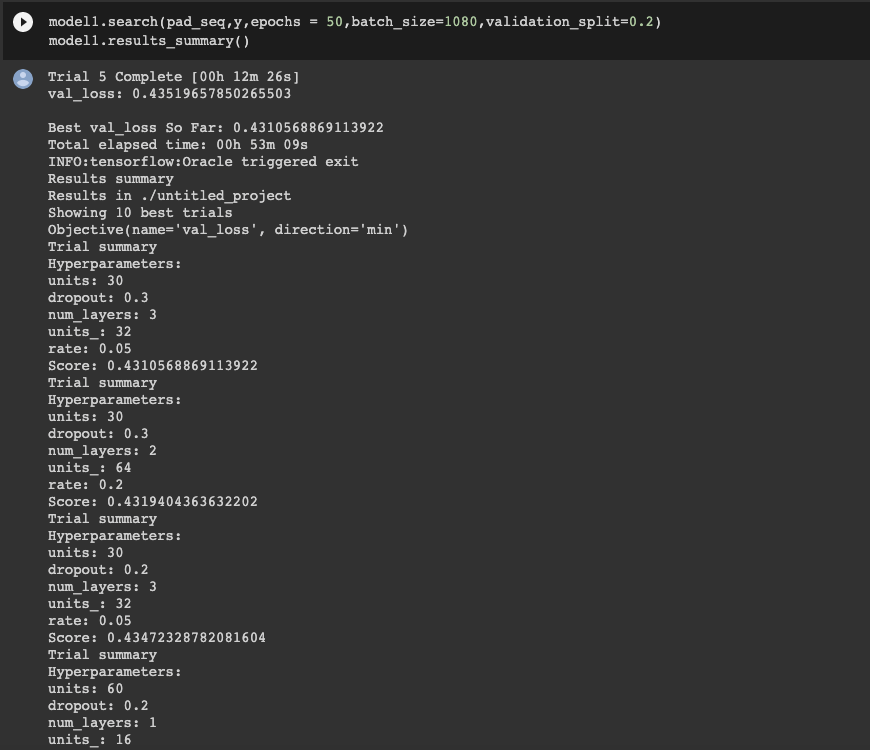

In [ ]:
# model1.search(pad_seq,y,epochs = 50,batch_size=1080,validation_split=0.2)
# model1.results_summary()

Trial 5 Complete [00h 12m 26s]
val_loss: 0.43519657850265503

Best val_loss So Far: 0.4310568869113922
Total elapsed time: 00h 53m 09s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 30
dropout: 0.3
num_layers: 3
units_: 32
rate: 0.05
Score: 0.4310568869113922
Trial summary
Hyperparameters:
units: 30
dropout: 0.3
num_layers: 2
units_: 64
rate: 0.2
Score: 0.4319404363632202
Trial summary
Hyperparameters:
units: 30
dropout: 0.2
num_layers: 3
units_: 32
rate: 0.05
Score: 0.43472328782081604
Trial summary
Hyperparameters:
units: 60
dropout: 0.2
num_layers: 1
units_: 16
rate: 0.2
Score: 0.43519657850265503
Trial summary
Hyperparameters:
units: 10
dropout: 0.2
num_layers: 1
units_: 32
rate: 0.1
Score: 0.4406653344631195


In [63]:
model1 = Sequential()
model1.add(Embedding(vocab_size, dim, input_length=300, trainable=False, weights=[embedding_matrix]))
model1.add(Bidirectional(LSTM(30, return_sequences=True, dropout=0.3)))
model1.add(GlobalMaxPool1D())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(.05))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

En caso de tener pesos descargados y querer evitar el entrenamiento, modifique, descomente y ejecute la siguiente celda

In [64]:
model1.load_weights(path + "/model1.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
#history = model1.fit(pad_seq,y,epochs = 50,batch_size=1080,validation_split=0.2)

Epoch 1/50
297/297 [==============================] - 25s 45ms/step - loss: 0.5817 - accuracy: 0.6881 - precision: 0.6937 - recall: 0.6780 - val_loss: 0.4787 - val_accuracy: 0.7706 - val_precision: 0.7711 - val_recall: 0.7649
Epoch 2/50
297/297 [==============================] - 12s 40ms/step - loss: 0.4897 - accuracy: 0.7613 - precision: 0.7684 - recall: 0.7500 - val_loss: 0.4612 - val_accuracy: 0.7809 - val_precision: 0.7738 - val_recall: 0.7894
Epoch 3/50
297/297 [==============================] - 12s 40ms/step - loss: 0.4720 - accuracy: 0.7737 - precision: 0.7766 - recall: 0.7685 - val_loss: 0.4541 - val_accuracy: 0.7851 - val_precision: 0.7747 - val_recall: 0.7998
Epoch 4/50
297/297 [==============================] - 12s 39ms/step - loss: 0.4622 - accuracy: 0.7791 - precision: 0.7820 - recall: 0.7749 - val_loss: 0.4483 - val_accuracy: 0.7887 - val_precision: 0.7967 - val_recall: 0.7712
Epoch 5/50
297/297 [==============================] - 12s 39ms/step - loss: 0.4541 - accuracy: 0

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


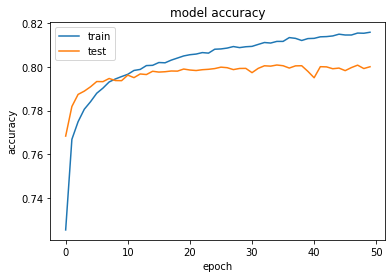

In [ ]:
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


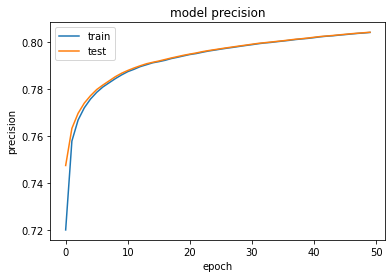

In [ ]:
# print(history.history.keys())
# # summarize history for precision
# plt.plot(history.history['precision'])
# plt.plot(history.history['val_precision'])
# plt.title('model precision')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


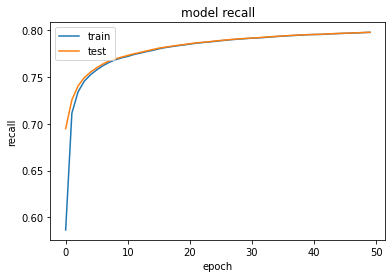

In [ ]:
# print(history.history.keys())
# # summarize history for recall
# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])
# plt.title('model recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

Si realizó el entrenamiento y desea guardar los pesos para futuras ocasiones, descomente y ejecute la siguiente celda

In [ ]:
#model1.save_weights(path + "/model1.h5")
#print("Saved model1 to drive")
 

Saved model1 to drive


##Second Model

In [ ]:
def create_model():
  model2 = Sequential()
  model2.add(Embedding(vocab_size, dim, input_length=300, trainable=False, weights=[embedding_matrix]))
  model2.add(GRU(60, return_sequences=True, dropout=0.2))
  model2.add(SimpleRNN(128))
  model2.add(Dense(10))
  model2.add(Dropout(.2))
  model2.add(Dense(32, activation='relu'))
  model2.add(Dense(1, activation='sigmoid'))

  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
  history2 = model2.fit(pad_seq,y,epochs = 30,validation_split=0.2)
  model2.save_weights(path + "/model2.h5")
  print("Saved model2 weights to drive")
  print("\n\n\n----------------------------\n\n\n")
  model2.summary()

El siguiente modelo requiere de potencia computacional, por lo que si se hará el entrenamiento, se recomienda el uso de TPU, para activarla descomente y ejecute las siguientes 2 celdas

In [ ]:
import os
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')

Found TPU at: grpc://10.98.253.218:8470


In [ ]:
# import tensorflow as tf
# use_tpu = True
# if use_tpu:
#     # Create distribution strategy
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)

#     # Create model
#     with strategy.scope():
#         model = create_model()
# else:
#     model = create_model()

INFO:tensorflow:Initializing the TPU system: grpc://10.98.253.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.253.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/30


10000/10000 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7298 - precision_1: 0.7389 - recall_1: 0.7074WARNING:tensorflow:Model was constructed with shape (None, 300) for input KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='embedding_1_input'), name='embedding_1_input', description="created by layer 'embedding_1_input'"), but it was called on an input with incompatible shape (4, 41).


10000/10000 [==============================] - 306s 30ms/step - loss: 0.5335 - accuracy: 0.7298 - precision_1: 0.7389 - recall_1: 0.7074 - val_loss: 0.4596 - val_accuracy: 0.7831 - val_precision_1: 0.7947 - val_recall_1: 0.7664
Epoch 2/30
10000/10000 [==============================] - 297s 30ms/step - loss: 0.4616 - accuracy: 0.7816 - precision_1: 0.7845 - recall_1: 0.7740 - val_loss: 0.4527 - val_accuracy: 0.7906 - val_precision_1: 0.7897 - val_recall_1: 0.7950
Epoch 3/30
10000/10000 [==============================] - 298s 30ms/step - loss: 0.4457 - accuracy: 0.7901 - precision_1: 0.7905 - recall_1: 0.7884 - val_loss: 0.4451 - val_accuracy: 0.7918 - val_precision_1: 0.7730 - val_recall_1: 0.8291
Epoch 4/30
10000/10000 [==============================] - 298s 30ms/step - loss: 0.4378 - accuracy: 0.7944 - precision_1: 0.7958 - recall_1: 0.7917 - val_loss: 0.4497 - val_accuracy: 0.7926 - val_precision_1: 0.8013 - val_recall_1: 0.7809
Epoch 5/30
10000/10000 [==============================]

In [65]:
model2 = Sequential()
model2.add(Embedding(vocab_size, dim, input_length=300, trainable=False, weights=[embedding_matrix]))
model2.add(GRU(60, return_sequences=True, dropout=0.2))
model2.add(SimpleRNN(128))
model2.add(Dense(10))
model2.add(Dropout(.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          84121800  
_________________________________________________________________
gru (GRU)                    (None, 300, 60)           65160     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 128)               24192     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

En caso de tener los pesos, ejecute la siguiente celda para cargarlos

In [66]:
model2.load_weights(path + '/model2.h5')

### Model 2 metrics

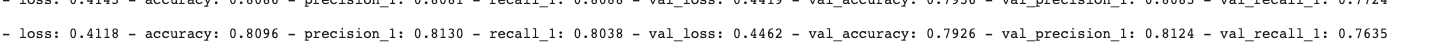

In [ ]:
#history2 = model2.fit(pad_seq,y,epochs = 30,validation_split=0.2)

Epoch 1/30
10000/10000 [==============================] - 315s 31ms/step - loss: 0.6955 - accuracy: 0.5016 - precision_1: 0.5000 - recall_1: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.5016 - val_precision_1: 0.5016 - val_recall_1: 1.0000
Epoch 2/30
10000/10000 [==============================] - 313s 31ms/step - loss: 0.6935 - accuracy: 0.4980 - precision_1: 0.4975 - recall_1: 0.4718 - val_loss: 0.6933 - val_accuracy: 0.5015 - val_precision_1: 0.5016 - val_recall_1: 0.9999
Epoch 3/30
10000/10000 [==============================] - 314s 31ms/step - loss: 0.6933 - accuracy: 0.4990 - precision_1: 0.4985 - recall_1: 0.5855 - val_loss: 0.6931 - val_accuracy: 0.5016 - val_precision_1: 0.5016 - val_recall_1: 1.0000
Epoch 4/30
10000/10000 [==============================] - 310s 31ms/step - loss: 0.6932 - accuracy: 0.4985 - precision_1: 0.4980 - recall_1: 0.5108 - val_loss: 0.6932 - val_accuracy: 0.4984 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/30
10000/10000 [============

In [ ]:
# print(history2.history.keys())
# # summarize history for accuracy
# plt.plot(history2.history['accuracy'])
# plt.plot(history2.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# print(history2.history.keys())
# # summarize history for precision
# plt.plot(history2.history['precision'])
# plt.plot(history2.history['val_precision'])
# plt.title('model precision')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# print(history2.history.keys())
# # summarize history for recall
# plt.plot(history2.history['recall'])
# plt.plot(history2.history['val_recall'])
# plt.title('model recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

##Third model

In [73]:
#Tercer Modelo RNN a utilizar
model3 = Sequential()
model3.add(Embedding(vocab_size, dim, input_length=300, trainable=False, weights=[embedding_matrix]))
model3.add(LSTM(30, return_sequences=True, recurrent_dropout=0.3, recurrent_activation="relu"))
model3.add(GlobalMaxPool1D())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(.05))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [75]:
# history3 = model3.fit(pad_seq,y,epochs = 10,validation_split=0.2)
# model3.save_weights(path + "/model3.h5")
# print("Saved model3 weights to drive")

Epoch 1/10
10000/10000 [==============================] - 683s 68ms/step - loss: 0.4821 - accuracy: 0.7686 - precision: 0.7757 - recall: 0.7563 - val_loss: 0.4723 - val_accuracy: 0.7742 - val_precision: 0.7827 - val_recall: 0.7567
Epoch 2/10
10000/10000 [==============================] - 676s 68ms/step - loss: 0.4588 - accuracy: 0.7834 - precision: 0.7877 - recall: 0.7765 - val_loss: 0.4653 - val_accuracy: 0.7773 - val_precision: 0.7852 - val_recall: 0.7610
Epoch 3/10
10000/10000 [==============================] - 683s 68ms/step - loss: 0.4509 - accuracy: 0.7885 - precision: 0.7951 - recall: 0.7780 - val_loss: 0.4630 - val_accuracy: 0.7810 - val_precision: 0.7835 - val_recall: 0.7743
Epoch 4/10
10000/10000 [==============================] - 679s 68ms/step - loss: 0.4464 - accuracy: 0.7901 - precision: 0.7958 - recall: 0.7810 - val_loss: 0.4616 - val_accuracy: 0.7814 - val_precision: 0.7816 - val_recall: 0.7786
Epoch 5/10
10000/10000 [==============================] - 681s 68ms/step - l

In [ ]:
model3.load_weights(path + "/model3.h5")
print("Loaded model from disk")

Loaded model from disk


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


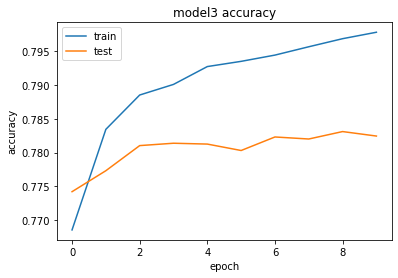

In [90]:
# print(history3.history.keys())
# # summarize history for accuracy
# plt.plot(history3.history['accuracy'])
# plt.plot(history3.history['val_accuracy'])
# plt.title('model3 accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


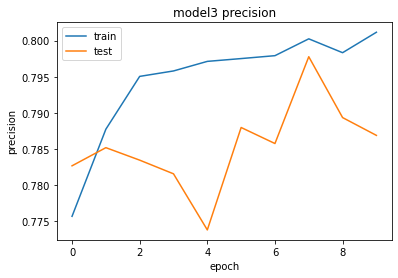

In [91]:
# print(history3.history.keys())
# # summarize history for precision
# plt.plot(history3.history['precision'])
# plt.plot(history3.history['val_precision'])
# plt.title('model3 precision')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


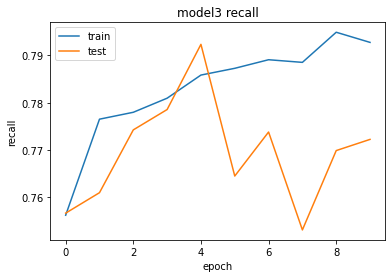

In [92]:
# print(history3.history.keys())
# # summarize history for recall
# plt.plot(history3.history['recall'])
# plt.plot(history3.history['val_recall'])
# plt.title('model3 recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#ASR

In [79]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model2 = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/asr-crdnn-rnnlm-librispeech")

In [84]:
def transcribe_video(fileList = []):
  listOfText = []
  if fileList == [] :
    uploaded = files.upload()
    listOfAudios = list(uploaded.keys())
  else:
    listOfAudios = fileList
  a = perf_counter()
  for file in listOfAudios:
    duration = librosa.get_duration(filename=file)
    j = 1
    i = 1
    video = moviepy.editor.VideoFileClip(os.getcwd() + "/" + file)
    audio = video.audio
    nameVideo = "AudioExtraction_Video_" + str(j) + (".wav")
    print("\nExporting audio from video: " + file + "\nTo: " + nameVideo)
    audio.write_audiofile(os.getcwd() + "/" + nameVideo)
    t1 = 0
    t2 = duration * 1000 if duration < 30 else 30000
    textTemp = ""
    
    final_fragment = False
    while t2 <= duration*1000 and not final_fragment:
      final_fragment = True if t2 == duration * 1000 else False
      newAudio = AudioSegment.from_wav(nameVideo)
      newAudio = newAudio[t1:t2]
      name = 'Video_' + str(j) + '_segment_' + str(i) + '.wav'
      newAudio.export(name, format="wav")
      t1 += 30000
      t2 = duration * 1000 if t2 + 30000 > duration * 1000 else t2 + 30000
      i+= 1
      print("\nAnalizando: " + name)
      resAux = asr_model2.transcribe_file(os.getcwd() + "/" + name)
      textTemp = textTemp + " " + resAux
    
    listOfText.append(textTemp[1:])
    j += 1
  print("\nTerminado en: " + str(f'{perf_counter() - a:.2f}') + " seg.\n")

  return listOfText

In [91]:
def transcribe_audio(fileList = []):
  listOfText = []
  if fileList == [] :
    uploaded = files.upload()
    listOfAudios = list(uploaded.keys())
  else:
    listOfAudios = fileList
  
  a = perf_counter()
  for file in listOfAudios:
    duration = librosa.get_duration(filename=file)
    t1 = 0
    t2 = duration * 1000 if duration < 30 else 30000
    textTemp = ""
    j = 1
    i = 1
    final_fragment = False
    while t2 <= duration*1000 and not final_fragment:
      final_fragment = True if t2 == duration * 1000 else False
      newAudio = AudioSegment.from_wav(file)
      newAudio = newAudio[t1:t2]
      name = 'Audio_' + str(j) + '_segment_' + str(i) + '.wav'
      newAudio.export(name, format="wav")
      t1 += 30000
      t2 = duration * 1000 if t2 + 30000 > duration * 1000 else t2 + 30000
      i+= 1
      print("\nAnalizando: " + name)
      resAux = asr_model2.transcribe_file(os.getcwd() + "/" + name)
      textTemp = textTemp + " " + resAux
    
    listOfText.append(textTemp[1:])
    j += 1
  print("\nTerminado en: " + str(f'{perf_counter() - a:.2f}') + " seg.\n")

  return listOfText



#Assembly function



In [93]:
def sentiment_assembly(text):
  counter = 0
  temp_seq = tokenizer.texts_to_sequences([text])
  temp_pad_seq = pad_sequences(temp_seq)

  v1 = model1.predict(temp_pad_seq)
  v1 = v1[0][0]

  v1 = 1 if v1 > 0.7 else 0

  v2 = model2.predict(temp_pad_seq)
  v2 = v2[0][0]

  v2 = 1 if v2 > 0.7 else 0

  v3 = model3.predict(temp_pad_seq)
  v3 = v3[0][0]

  v3 = 1 if v3 > 0.7 else 0
  
  return 'Positive' if v1+v2+v3 >= 2 else 'Negative'

In [ ]:
#sentiment_assembly('I love my life')

'Positive'

#Twitter

Para una búsqueda personalizada, puede cambiar la variable username por la cuenta que desee y la variable nTweets para conseguir los últimos n tweets de la cuenta

In [83]:
Tweets = []
Username = "@Twitter"
nTweets = 100
Tweets_Usuario = []

#consumer key, consumer secret, access token, access secret.
ckey="rDSsKWQKlFfKAvdGG5bKCt3D5"
csecret="lGngTfmXozAojLl3F5xZnhCkuLISxXWkHGwr8b7BIc806Qho8J"
atoken="3310850076-jf4yOAp9UfWR3oceqOXzsMWgqYslv2pBElmRHqb"
asecret="S7uLkkdvbZVKsYORhoZo3J1zs0OrOjJAhf9vggxiWQ5Bj"

class listener(StreamListener):

    def on_data(self, data):
        all_data = json.loads(data)

        tweet = all_data["text"]
        Tweets.append(tweet)
        
        value = sentiment_assembly(tweet)

        if value == 'Positive':
          outP = open((path + "/Twitter_Positive_results.txt"), "a")
          outP.write(value +  " - " + tweet)
          outP.write("\n")
          outP.close()
        else:
          outN = open((path + "/Twitter_Negative_results.txt"), "a")
          outN.write(value +  " - " + tweet)
          outN.write("\n")
          outN.close()

        print(tweet)


        return True

    def on_error(self, status):
        print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#search tweets by user
print("Tuits por usuario")
for status in tweepy.Cursor(api.user_timeline, screen_name=Username, tweet_mode="extended").items():
    Tweets_Usuario.append(status.full_text)


Tuits por usuario


Esta celda debe ser detenida manualmente cuando se quiera detener la extracción de tweets

In [76]:
twitterStream = Stream(auth, listener())
twitterStream.filter(track=["podcast"])

📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日04:37 開始予定（日本時間）
野球 / メジャーリーグ
Oakland Athletics vs Los… https://t.co/cy4Q7zknY8
📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日05:10 開始予定（日本時間）
野球 / メジャーリーグ
Milwaukee Brewers vs Kans… https://t.co/Fum1QvU99V
RT @riocarmine: Anyone who’s ever been to an #NERevs game at Gillette knows that playing in someone else’s house is … well, less than ideal…
📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日08:05 開始予定（日本時間）
野球 / メジャーリーグ
Washington Nationals vs M… https://t.co/v1KFeEN4Ka
📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日08:05 開始予定（日本時間）
野球 / メジャーリーグ
New York Yankees vs Phila… https://t.co/nOIcZc4o6K
📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日08:10 開始予定（日本時間）
野球 / メジャーリーグ
Detroit Tigers vs Texas R… https://t.co/eDY94ZpTAN
📈ベットシード
#ブックメーカー #オッズ速報
以下の試合のオープニングオッズが発表されました

2021年07月21日08:10 開始予定（日本時間）
野球 / メジャーリーグ
Tampa Bay Rays vs Baltimo… https://t.co/hAJ7ykisJh
📈ベットシード
#ブックメー

KeyboardInterrupt: ignored

##Tweets by user


In [76]:
def tweets_by_user():
  for tweet in Tweets_Usuario:
    value = sentiment_assembly(tweet)

    if value == 'Positive':
      outP = open((path + "/Twitter_By_User_Positive_results.txt"), "a")
      outP.write(value +  " - " + tweet)
      outP.write("\n")
      outP.close()
    else:
      outN = open((path + "/Twitter_By_User_Negative_results.txt"), "a")
      outN.write(value +  " - " + tweet)
      outN.write("\n")
      outN.close()

    print(tweet)

#From audio

In [84]:
def sentiment_audio():
  audio_to_text = transcribe_audio()
  
  for audio in audio_to_text:
  
    value = sentiment_assembly(audio)

    if value == 'Positive':
      outP = open((path + "/Audios_Positive_results.txt"), "a")
      outP.write(value +  " - " + audio)
      outP.write("\n")
      outP.close()
    else:
      outN = open((path + "/Audios_Negative_results.txt"), "a")
      outN.write(value +  " - " + audio)
      outN.write("\n")
      outN.close()

    print(audio)



In [95]:
sentiment_audio()

Saving 49m2a-kddi3.wav to 49m2a-kddi3 (3).wav

Analizando: Audio_1_segment_1.wav

Terminado en: 121.96 seg.

THE MINIMUM NUMBER OF ENVELOPES IS EIGHT DID YOU TAKE NOTICE OF HIS SUCCESS DID YOU SUCCEED IN GETTING THE MINIMUM NUMBER OF NOTICES IN THE ENVELOPE I NOTICED THAT HIS SUCCESSFUL ENTRY HAD THE MINIMUM NUMBER OF WORDS I NOTICED THAT SHE IS ENJOYING MANY SUCCESSES WE SUCCEEDED IN OUR MARKETING CLAIM BECAUSE WE USED BRIGHT RED ENVELOPES WE ARE TRYING TO FIT ALL OF OUR PUZZLE PIECES TOGETHER IN A LOGICAL MANNER IT IS JUST AS IF YOU ARE BUILDING A PUZZLE BY REFERRING TO THEE


#From Video

In [85]:
def sentiment_video(video):
  video_to_text = transcribe_video([video])
  
  for video in video_to_text:
  
    value = sentiment_assembly(video)

    if value == 'Positive':
      outP = open((path + "/Videos_Positive_results.txt"), "a")
      outP.write(value +  " - " + video)
      outP.write("\n")
      outP.close()
    else:
      outN = open((path + "/Videos_Negative_results.txt"), "a")
      outN.write(value +  " - " + video)
      outN.write("\n")
      outN.close()

    print(video)


#Transformers

In [4]:
from transformers import pipeline
sentimentanalyzer = pipeline("sentiment-analysis")
sentimentanalyzer2 = pipeline("sentiment-analysis", model = "nlptown/bert-base-multilingual-uncased-sentiment")
sentimentanalyzer3 = pipeline("sentiment-analysis", model = "rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

result = sentimentanalyzer("I really don't like what you did")[0]
print(f"Sentiment: {result['label']}")

Sentiment: NEGATIVE


In [5]:
#result = sentimentanalyzer3("I really don't like what you did")

In [6]:
#result[0]['label']

'LABEL_1'

##Assembly with transformers

In [86]:

def calc_sen(text):
  return sentimentanalyzer(text)[0]['label'], sentimentanalyzer2(text)[0]['label'], sentimentanalyzer3(text)[0]['label']

In [87]:
def sentiment_transformers(text):
  counterP = 0
  counterNeu = 0
  v1, v2, v3 = calc_sen(text)

  if v1 == 'POSITIVE':
    counterP += 1

  if v2 == '4 stars' or v2 == '5 stars':
    counterP +=1

  if v2 == '3 stars':
    counterNeu +=1

  if v3 == 'LABEL_2':
    counterP += 1
  if v3 == 'LABEL_1':
    counterNeu +=1

  if counterP >2 or (counterP == 1 and counterNeu >=1):
    value = 'Positive'
  elif counterNeu == 2:
    value = 'Neutral'
  elif counterP <= 1:
    value = 'Negative' 

  if value == 'Positive':
    outP = open((path + "/Transformers_Positive_results.txt"), "a")
    outP.write(value +  " - " + text)
    outP.write("\n")
    outP.close()
  elif value == 'Negative':
    outN = open((path + "/Transformers_Negative_results.txt"), "a")
    outN.write(value +  " - " + text)
    outN.write("\n")
    outN.close()
  else:
    outN = open((path + "/Transformers_Neutral_results.txt"), "a")
    outN.write(value +  " - " + text)
    outN.write("\n")
    outN.close()

  print(value)




In [28]:
sentiment_transformers('I love my life')

Positive


#Reddit

In [ ]:
CLIENT_ID = "-J0czzbhT-t1boL-dS52KA"
CLIENT_SECRET = "8dDh4CagRnQmk8P9RWluM2RHZMqzBw"
USER_AGENT = "nlp-itesm-act-2"

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT,
    check_for_async=False
)

In [ ]:
def clean_post_text(text):
  # print(text)
  text = re.sub(r'(?:__|[*#])|\[(.*?)\]\(.*?\)', r'\1', text) # Removes Markdown Syntax
  text = re.sub(r'\/?r\/', '', text) # Removes r/ subreddit mentions
  text = re.sub(r'u\\?\/', '', text) # Removes u/ user mentions
  return text


En caso de querer extraer post de otra cuenta se debe de cambiar en:

```python
for submission in reddit.redditor(<username_deseado>).submissions.new(limit=1000):
```

In [ ]:
post_texts = []
post_titles = []
for submission in reddit.redditor("spez").submissions.new(limit=1000):
  if submission.selftext:
    post_texts.append(clean_post_text(submission.selftext))
  post_titles.append(submission.title)

# print(post_titles)
# print(post_texts)

['An update on the recent issues surrounding a Reddit employee', 'Today we’re testing a new way to discuss political ads (and announcements)', 'Today we’re testing a new way to discuss political ads (and announcements)', 'Update to Our Content Policy', 'Upcoming changes to our content policy, our board, and where we’re going from here', 'Spring forward… into Reddit’s 2019 transparency report', 'Reddit’s 2018 transparency report (and maybe other stuff)', 'You have thousands of questions, I have dozens of answers! Reddit CEO here, AMA.', 'Despite everyone saying the redesign is perfect, please align these before we all go insane.', 'Reddit’s 2017 transparency report and suspect account findings', "Let's see if you can hold off betraying long enough to make this interesting. I'll donate $1 for every member of this circle to the highest voted charity.", 'In response to recent reports about the integrity of Reddit, I’d like to share our thinking.', 'Not my first, could be my last, State of 

In [88]:
def reddit_post():
  for title in post_titles:
    value = sentiment_assembly(title)

    if value == 'Positive':
      outP = open((path + "/Reddit_Titles_Positive_results.txt"), "a")
      outP.write(value +  " - " + title)
      outP.write("\n")
      outP.close()
    else:
      outN = open((path + "/Reddit_Titles_Negative_results.txt"), "a")
      outN.write(value +  " - " + title)
      outN.write("\n")
      outN.close()

    print(title)

  for post in post_texts:
    value = sentiment_assembly(post)

    if value == 'Positive':
      outP = open((path + "/Reddit_Posts_Positive_results.txt"), "a")
      outP.write(value +  " - " + post)
      outP.write("\n")
      outP.close()
    else:
      outN = open((path + "/Reddit_Posts_Negative_results.txt"), "a")
      outN.write(value +  " - " + post)
      outN.write("\n")
      outN.close()

    print(post)

#From Youtube video


Al llamar la función, debe de enviar como parámetro el link del video de youtube que desee

In [89]:
def youtube_video(youtube_link):

  video = YouTube(youtube_link)
  video.streams.filter(file_extension = "mp4")[0].download(filename= "youtubeVideo")

  sentiment_video("youtubeVideo.mp4")

